<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Guillermo Cortés Medina</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


Cargando imágenes: 100%|██████████| 14328/14328 [00:53<00:00, 268.60it/s]


Total de imágenes cargadas: 14328
Clases encontradas: {'box', 'cross', 'circle'}
Plantillas cargadas:
- box: (8, 8, 3)
- circ: (8, 8, 3)
- cross: (8, 8, 3)


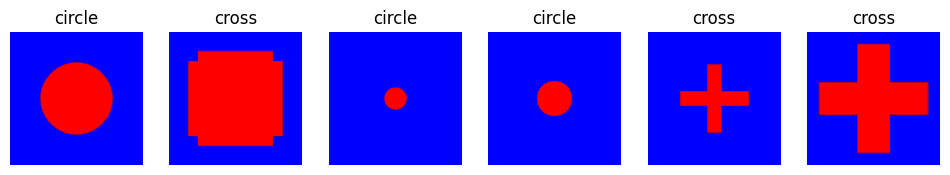

In [ ]:
import os
import cv2
import numpy as np
import torch
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# PARTE 1 - CARGA Y PREPROCESAMIENTO

def cargar_imagenes_y_etiquetas(ruta_carpeta, nueva_dim=(128, 128), como_tensor=False):
    rutas = sorted(glob(os.path.join(ruta_carpeta, '*.png')))
    imagenes = []
    etiquetas = []
    nombres = []

    for ruta in tqdm(rutas, desc="Cargando imágenes"):
        img = cv2.imread(ruta)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, nueva_dim, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0

        if como_tensor:
            img = torch.tensor(img).permute(2, 0, 1)  # [C, H, W]

        imagenes.append(img)

        nombre = os.path.basename(ruta).lower()
        if 'cross' in nombre:
            etiquetas.append('cross')
        elif 'box' in nombre:
            etiquetas.append('box')
        elif 'circ' in nombre:
            etiquetas.append('circle')
        else:
            etiquetas.append('desconocida')

        nombres.append(nombre)

    return imagenes, etiquetas, nombres

def cargar_templates(ruta_templates, nueva_dim=(8, 8)):
    rutas_templates = sorted(glob(os.path.join(ruta_templates, '*.png')))
    templates = {}
    for ruta in rutas_templates:
        nombre = os.path.basename(ruta).lower()
        img = cv2.imread(ruta)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, nueva_dim, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        if 'cross' in nombre:
            templates['cross'] = img
        elif 'box' in nombre:
            templates['box'] = img
        elif 'circ' in nombre:
            templates['circ'] = img
    return templates

def mostrar_muestras(imagenes, etiquetas, n=6):
    plt.figure(figsize=(12, 4))
    idx = np.random.choice(len(imagenes), n, replace=False)
    for i, iidx in enumerate(idx):
        plt.subplot(1, n, i+1)
        plt.imshow(imagenes[iidx])
        plt.title(etiquetas[iidx])
        plt.axis('off')
    plt.show()

# USO DEL CÓDIGO

ruta_imagenes = './imagenes/'       
ruta_templates = './plantillas/'

# Carga con redimensionamiento a 128x128 y templates a 8x8
imagenes, etiquetas, nombres = cargar_imagenes_y_etiquetas(ruta_imagenes, nueva_dim=(128, 128), como_tensor=False)
templates = cargar_templates(ruta_templates, nueva_dim=(8, 8))

print(f"Total de imágenes cargadas: {len(imagenes)}")
print(f"Clases encontradas: {set(etiquetas)}")
print("Plantillas cargadas:")
for clase, temp in templates.items():
    print(f"- {clase}: {temp.shape}")

# Visualización aleatoria de algunas muestras
mostrar_muestras(imagenes, etiquetas, n=6)


## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

Transformando imágenes: 100%|██████████| 14328/14328 [00:07<00:00, 1869.24it/s]


Imágenes y plantillas transformadas listas.
Dimensión imagen ejemplo: (64, 64)
Dimensión plantilla ejemplo: (4, 4)


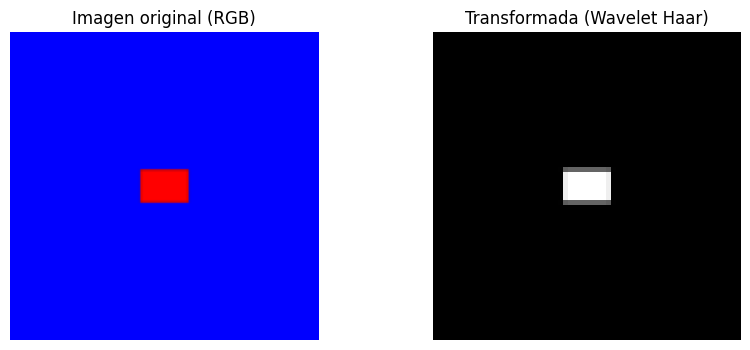

In [ ]:
import cv2
import numpy as np
import pywt
from tqdm import tqdm
import matplotlib.pyplot as plt

# FUNCIÓN DE PREPROCESAMIENTO INDIVIDUAL

def preprocesar_imagen(img_rgb, usar_wavelet=False):
    # Convertir a escala de grises
    img_gray = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    img_gray = img_gray.astype(np.float32) / 255.0  # Normaliza a [0, 1]

    if usar_wavelet:
        # Transformada wavelet Haar
        cA, (cH, cV, cD) = pywt.dwt2(img_gray, 'haar')
        return cA  # Solo se usa la componente aproximada ("resumen de la imagen")

    return img_gray

# PREPROCESAMIENTO MASIVO DE IMÁGENES

def transformar_conjunto(imagenes_rgb, usar_wavelet=False):
    transformadas = []
    for img in tqdm(imagenes_rgb, desc="Transformando imágenes"):
        transformadas.append(preprocesar_imagen(img, usar_wavelet=usar_wavelet))
    return transformadas

# PREPROCESAMIENTO DE TEMPLATES

def transformar_templates(templates_rgb, usar_wavelet=False):
    templates_transformados = {}
    for clase, img in templates_rgb.items():
        templates_transformados[clase] = preprocesar_imagen(img, usar_wavelet=usar_wavelet)
    return templates_transformados

# APLICACIÓN

usar_wavelet = True  # True = usa Haar// False = usaría escala de grises normalizada

# Preprocesamiento
imagenes_proc = transformar_conjunto(imagenes, usar_wavelet=usar_wavelet)
templates_proc = transformar_templates(templates, usar_wavelet=usar_wavelet)

print("Imágenes y plantillas transformadas listas.")
print(f"Dimensión imagen ejemplo: {imagenes_proc[0].shape}")
print(f"Dimensión plantilla ejemplo: {list(templates_proc.values())[0].shape}")

# VISUALIZACIÓN DE RESULTADOS

def visualizar_transformacion(idx=0):
    original = imagenes[idx]
    transformada = imagenes_proc[idx]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Imagen original (RGB)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformada, cmap='gray')
    titulo = "Transformada (Wavelet Haar)" if usar_wavelet else "Escala de grises normalizada"
    plt.title(titulo)
    plt.axis('off')

    plt.show()

# Mostrar una imagen de ejemplo
visualizar_transformacion(idx=0)


## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


Clasificando imágenes: 100%|██████████| 14328/14328 [00:05<00:00, 2604.80it/s]


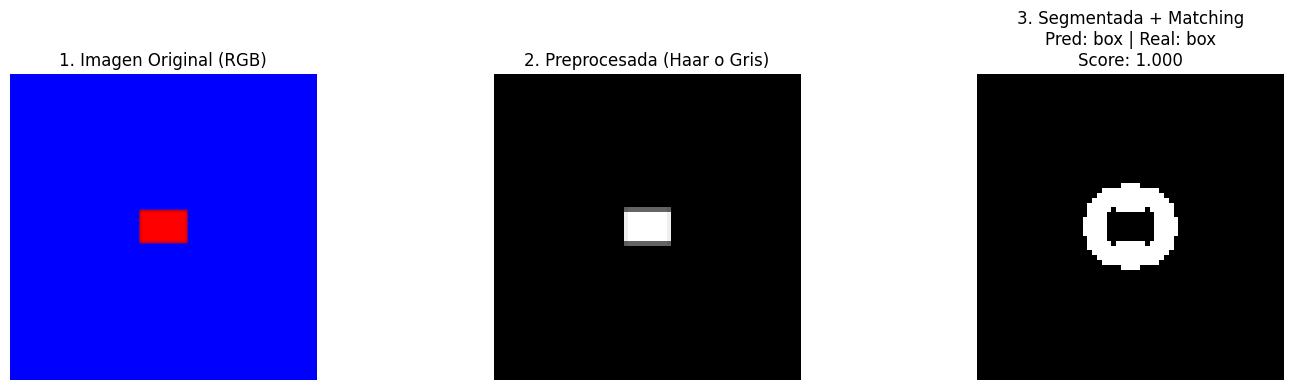

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# FUNCIÓN DE SEGMENTACIÓN y NORMALIZACIÓN

def segmentar_y_normalizar(img):
    # Contraste local
    img_eq = cv2.equalizeHist((img * 255).astype(np.uint8))
    img_eq = img_eq.astype(np.float32) / 255.0

    # Segmentación
    img_bin = cv2.adaptiveThreshold(
        (img_eq * 255).astype(np.uint8),
        maxValue=1,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=5
    ).astype(np.float32)

    return img_bin


# SEGMENTACIÓN PARATODAS LAS IMÁGENES

def aplicar_segmentacion(imagenes_proc):
    return [segmentar_y_normalizar(img) for img in tqdm(imagenes_proc, desc="Segmentando imágenes")]

def aplicar_segmentacion_templates(templates_proc):
    return {k: segmentar_y_normalizar(v) for k, v in templates_proc.items()}

# MATCHING y CLASIFICACIÓN POR CONVOLUCIÓN

def clasificar_imagen(img_bin, templates_dict_bin):
    min_score = np.inf
    prediccion = None

    for clase, template in templates_dict_bin.items():
        if np.std(img_bin) < 1e-6 or np.std(template) < 1e-6:
            continue

        res = cv2.matchTemplate(img_bin, template, method=cv2.TM_SQDIFF_NORMED)
        min_val, _, _, _ = cv2.minMaxLoc(res)

        if min_val < min_score:
            min_score = min_val
            prediccion = clase

    # Si se puede comparar, marcar como desconocido
    if prediccion is None:
        return 'desconocido', 1.0

    return prediccion, 1 - min_score  # para que el 'score' siga siendo interpretado como "mejor = más alto"


def clasificar_todas(imagenes_bin, templates_bin):
    predicciones = []
    puntajes = []

    for img in tqdm(imagenes_bin, desc="Clasificando imágenes"):
        pred, score = clasificar_imagen(img, templates_bin)
        predicciones.append(pred)
        puntajes.append(score)

    return predicciones, puntajes

# APLICACIÓN COMPLETA DE LA PRTE 3

# Segmenta y normaliza
imagenes_bin = aplicar_segmentacion(imagenes_proc)
templates_bin = aplicar_segmentacion_templates(templates_proc)

# Clasifica
predicciones, puntajes = clasificar_todas(imagenes_bin, templates_bin)

# VISUALIZACIÓN COMPLETA DE LAS 3 PARTES

def mostrar_etapas_operaciones(idx=0):
    plt.figure(figsize=(15, 4))

    # Imagen original RGB
    plt.subplot(1, 3, 1)
    plt.imshow(imagenes[idx])
    plt.title("1. Imagen Original (RGB)")
    plt.axis('off')

    # Imagen preprocesada: gris o Haar
    plt.subplot(1, 3, 2)
    plt.imshow(imagenes_proc[idx], cmap='gray')
    plt.title("2. Preprocesada (Haar o Gris)")
    plt.axis('off')

    # Imagen segmentada: binarizada
    plt.subplot(1, 3, 3)
    plt.imshow(imagenes_bin[idx], cmap='gray')
    plt.title(f"3. Segmentada + Matching\nPred: {predicciones[idx]} | Real: {etiquetas[idx]}\nScore: {puntajes[idx]:.3f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar ejemplo visual con idx=0
mostrar_etapas_operaciones(idx=0)


## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

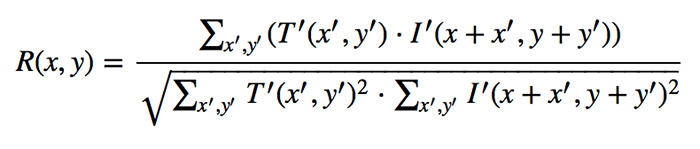

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia. 
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [ ]:
import time
import numpy as np

# FUNCIÓN DE MATCHING POR LOTES

def matching_por_lotes(imagenes_bin, templates_bin, etiquetas_reales, batch_size=500):
    predicciones_totales = []
    puntajes_totales = []
    etiquetas_totales = []

    total = len(imagenes_bin)
    n_batches = (total + batch_size - 1) // batch_size

    for i in range(n_batches):
        inicio = i * batch_size
        fin = min((i + 1) * batch_size, total)

        batch_imgs = imagenes_bin[inicio:fin]
        batch_etqs = etiquetas_reales[inicio:fin]

        print(f"\nProcesando batch {i+1}/{n_batches} - Imágenes {inicio} a {fin-1}")

        batch_preds, batch_scores = clasificar_todas(batch_imgs, templates_bin)

        predicciones_totales.extend(batch_preds)
        puntajes_totales.extend(batch_scores)
        etiquetas_totales.extend(batch_etqs)

    return predicciones_totales, puntajes_totales, etiquetas_totales

# CÁLCULO MANUAL DE PRECISIÓN

def calcular_accuracy(y_real, y_pred):
    aciertos = sum([pred == real for pred, real in zip(y_pred, y_real)])
    total = len(y_real)
    errores = total - aciertos
    return aciertos / total, errores

# APLICACIÓN DEL MATCHING Y EVALUACIÓN

# Inicia cronómetro
tiempo_inicio = time.time()

# Matching por lotes
preds_finales, scores_finales, y_reales = matching_por_lotes(
    imagenes_bin, templates_bin, etiquetas, batch_size=500
)

# Tiempo total
tiempo_total = time.time() - tiempo_inicio

# Precisión y errores
accuracy_total, errores = calcular_accuracy(y_reales, preds_finales)

# Resultados globales
print("\n--- RESULTADOS GLOBALES ---")
print(f"Precisión (accuracy): {accuracy_total:.4f}")
print(f"Errores de clasificación: {errores} / {len(y_reales)}")
print(f"Tiempo total de procesamiento: {tiempo_total:.2f} segundos")



Procesando batch 1/29 - Imágenes 0 a 499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2632.61it/s]



Procesando batch 2/29 - Imágenes 500 a 999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2581.76it/s]



Procesando batch 3/29 - Imágenes 1000 a 1499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2646.27it/s]



Procesando batch 4/29 - Imágenes 1500 a 1999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2640.96it/s]



Procesando batch 5/29 - Imágenes 2000 a 2499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2703.69it/s]



Procesando batch 6/29 - Imágenes 2500 a 2999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2683.00it/s]



Procesando batch 7/29 - Imágenes 3000 a 3499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2643.04it/s]



Procesando batch 8/29 - Imágenes 3500 a 3999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2628.30it/s]



Procesando batch 9/29 - Imágenes 4000 a 4499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2402.70it/s]



Procesando batch 10/29 - Imágenes 4500 a 4999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2633.77it/s]



Procesando batch 11/29 - Imágenes 5000 a 5499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2611.17it/s]



Procesando batch 12/29 - Imágenes 5500 a 5999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2676.52it/s]



Procesando batch 13/29 - Imágenes 6000 a 6499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2622.53it/s]



Procesando batch 14/29 - Imágenes 6500 a 6999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2657.52it/s]



Procesando batch 15/29 - Imágenes 7000 a 7499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2561.32it/s]



Procesando batch 16/29 - Imágenes 7500 a 7999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2485.76it/s]



Procesando batch 17/29 - Imágenes 8000 a 8499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2569.23it/s]



Procesando batch 18/29 - Imágenes 8500 a 8999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2468.57it/s]



Procesando batch 19/29 - Imágenes 9000 a 9499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2552.97it/s]



Procesando batch 20/29 - Imágenes 9500 a 9999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2413.68it/s]



Procesando batch 21/29 - Imágenes 10000 a 10499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2596.99it/s]



Procesando batch 22/29 - Imágenes 10500 a 10999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2341.84it/s]



Procesando batch 23/29 - Imágenes 11000 a 11499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2592.95it/s]



Procesando batch 24/29 - Imágenes 11500 a 11999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2604.28it/s]



Procesando batch 25/29 - Imágenes 12000 a 12499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2576.52it/s]



Procesando batch 26/29 - Imágenes 12500 a 12999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2608.88it/s]



Procesando batch 27/29 - Imágenes 13000 a 13499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2606.36it/s]



Procesando batch 28/29 - Imágenes 13500 a 13999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2603.92it/s]



Procesando batch 29/29 - Imágenes 14000 a 14327


Clasificando imágenes: 100%|██████████| 328/328 [00:00<00:00, 2559.48it/s]


--- RESULTADOS GLOBALES ---
Precisión (accuracy): 0.2710
Errores de clasificación: 10445 / 14328
Tiempo total de procesamiento: 5.61 segundos


# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.



--- CLASIFICACIÓN FINAL ---
Total de imágenes: 14328
Aciertos: 3883
Errores: 10445
Precisión: 0.2710
Error de clasificación: 0.7290

Mostrando dos ejemplos correctamente clasificados:


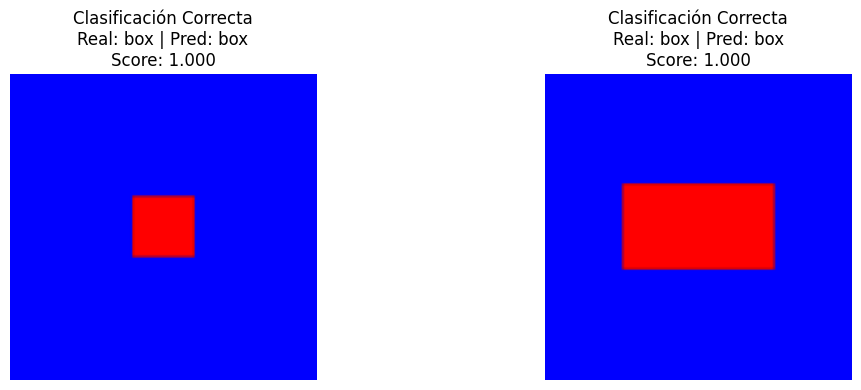


Mostrando dos ejemplos incorrectamente clasificados:


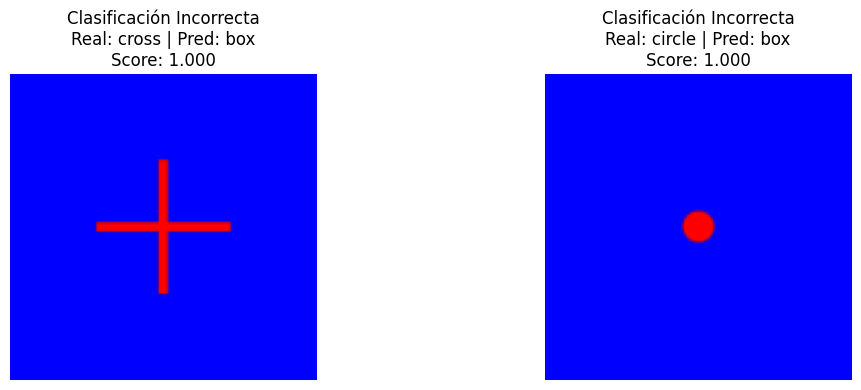

In [ ]:
import matplotlib.pyplot as plt
import random

# CÁLCULO FINAL DE MÉTRICAS

total_imagenes = len(y_reales)
aciertos = sum([p == r for p, r in zip(preds_finales, y_reales)])
errores = total_imagenes - aciertos
accuracy = aciertos / total_imagenes
error_clasificacion = errores / total_imagenes

print("\n--- CLASIFICACIÓN FINAL ---")
print(f"Total de imágenes: {total_imagenes}")
print(f"Aciertos: {aciertos}")
print(f"Errores: {errores}")
print(f"Precisión: {accuracy:.4f}")
print(f"Error de clasificación: {error_clasificacion:.4f}")

# IDENTIFICAR EJEMPLOS VERDADEROS Y FALSOS

indices_bien = [i for i in range(total_imagenes) if preds_finales[i] == y_reales[i]]
indices_mal = [i for i in range(total_imagenes) if preds_finales[i] != y_reales[i]]

ej_bien = random.sample(indices_bien, 2)
ej_mal = random.sample(indices_mal, 2)

# FUNCIÓN DE VISUALIZACIÓN DE EJEMPLOS

def mostrar_ejemplos(indices, titulo_general):
    plt.figure(figsize=(12, 4))
    for j, idx in enumerate(indices):
        plt.subplot(1, len(indices), j + 1)
        plt.imshow(imagenes[idx])
        plt.title(f"{titulo_general}\nReal: {y_reales[idx]} | Pred: {preds_finales[idx]}\nScore: {scores_finales[idx]:.3f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# VISUALIZACIÓN DE EJEMPLOS CORRECTOS Y ERRÓNEOS

print("\nMostrando dos ejemplos correctamente clasificados:")
mostrar_ejemplos(ej_bien, "Clasificación Correcta")

print("\nMostrando dos ejemplos incorrectamente clasificados:")
mostrar_ejemplos(ej_mal, "Clasificación Incorrecta")


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [ ]:
from timeit import default_timer as timer

# MEDICIÓN DE TIEMPO DE EJECUCIÓN COMPLETO

start = timer()  # INICIO

# Matching por lotes
preds_finales, scores_finales, y_reales = matching_por_lotes(
    imagenes_bin, templates_bin, etiquetas, batch_size=500
)

end = timer()  # FIN

tiempo_total = end - start

# CÁLCULO FINAL DE PRECISIÓN

def calcular_accuracy(y_real, y_pred):
    aciertos = sum([pred == real for pred, real in zip(y_pred, y_real)])
    total = len(y_real)
    errores = total - aciertos
    return aciertos / total, errores

accuracy_total, errores = calcular_accuracy(y_reales, preds_finales)

# RESULTADOS FINALES

print("\n--- RESULTADOS FINALES ---")
print(f"Precisión (accuracy): {accuracy_total:.4f}")
print(f"Errores de clasificación: {errores} / {len(y_reales)}")
print(f"Tiempo total de procesamiento: {tiempo_total:.2f} segundos")




Procesando batch 1/29 - Imágenes 0 a 499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2523.04it/s]



Procesando batch 2/29 - Imágenes 500 a 999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2588.44it/s]



Procesando batch 3/29 - Imágenes 1000 a 1499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2684.09it/s]



Procesando batch 4/29 - Imágenes 1500 a 1999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2643.27it/s]



Procesando batch 5/29 - Imágenes 2000 a 2499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2591.66it/s]



Procesando batch 6/29 - Imágenes 2500 a 2999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2474.88it/s]



Procesando batch 7/29 - Imágenes 3000 a 3499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2628.34it/s]



Procesando batch 8/29 - Imágenes 3500 a 3999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2513.61it/s]



Procesando batch 9/29 - Imágenes 4000 a 4499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2605.18it/s]



Procesando batch 10/29 - Imágenes 4500 a 4999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2563.27it/s]



Procesando batch 11/29 - Imágenes 5000 a 5499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2412.21it/s]



Procesando batch 12/29 - Imágenes 5500 a 5999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2588.76it/s]



Procesando batch 13/29 - Imágenes 6000 a 6499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2630.02it/s]



Procesando batch 14/29 - Imágenes 6500 a 6999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2608.76it/s]



Procesando batch 15/29 - Imágenes 7000 a 7499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2558.80it/s]



Procesando batch 16/29 - Imágenes 7500 a 7999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2616.39it/s]



Procesando batch 17/29 - Imágenes 8000 a 8499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2606.70it/s]



Procesando batch 18/29 - Imágenes 8500 a 8999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2575.90it/s]



Procesando batch 19/29 - Imágenes 9000 a 9499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2584.96it/s]



Procesando batch 20/29 - Imágenes 9500 a 9999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2582.02it/s]



Procesando batch 21/29 - Imágenes 10000 a 10499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2524.39it/s]



Procesando batch 22/29 - Imágenes 10500 a 10999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2465.55it/s]



Procesando batch 23/29 - Imágenes 11000 a 11499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2588.50it/s]



Procesando batch 24/29 - Imágenes 11500 a 11999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2594.89it/s]



Procesando batch 25/29 - Imágenes 12000 a 12499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2239.70it/s]



Procesando batch 26/29 - Imágenes 12500 a 12999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2590.05it/s]



Procesando batch 27/29 - Imágenes 13000 a 13499


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2508.60it/s]



Procesando batch 28/29 - Imágenes 13500 a 13999


Clasificando imágenes: 100%|██████████| 500/500 [00:00<00:00, 2520.62it/s]



Procesando batch 29/29 - Imágenes 14000 a 14327


Clasificando imágenes: 100%|██████████| 328/328 [00:00<00:00, 2544.83it/s]


--- RESULTADOS FINALES ---
Precisión (accuracy): 0.2710
Errores de clasificación: 10445 / 14328
Tiempo total de procesamiento: 5.66 segundos
